Imports

In [100]:
__author__ = "Artur Fejklowicz"

# Sources:
# - https://medium.com/@ashins1997/text-classification-dfe370bf7044
# - https://www.kaggle.com/code/shahkan/text-classification-using-logistic-regression
# - https://www.kaggle.com/code/satishgunjal/multiclass-logistic-regression-using-sklearn
# - https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a
# - https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from google.cloud import bigquery
import matplotlib.pyplot as plt
import nltk.stem.snowball
from sklearn.metrics import ConfusionMatrixDisplay
import nltk
from nltk.corpus import stopwords
#import seaborn as sns
import urllib.request



Retrive data from BigQuery

In [101]:
client = bigquery.Client(project="af-finanzen")
query = ("""SELECT
  description
  -- , Konto
  , CASE 
      WHEN Konto in ("PK Auto", "PK Maja", "PK Rest", "SK Haushalt", "Top-Up") THEN "Others"
      ELSE Konto
    END as Konto
FROM banks.revolut_mapping_internal
""")
df = client.query(query).to_dataframe()  # API request


## Data analysis

Basic

Number of classes: 5
Class names: ['Others' 'PK Artur' 'PK Leben' 'PK Reisen' 'SK Ferien']
Konto
Others        66
PK Artur      75
PK Leben     105
PK Reisen     70
SK Ferien     86
Name: Konto, dtype: int64


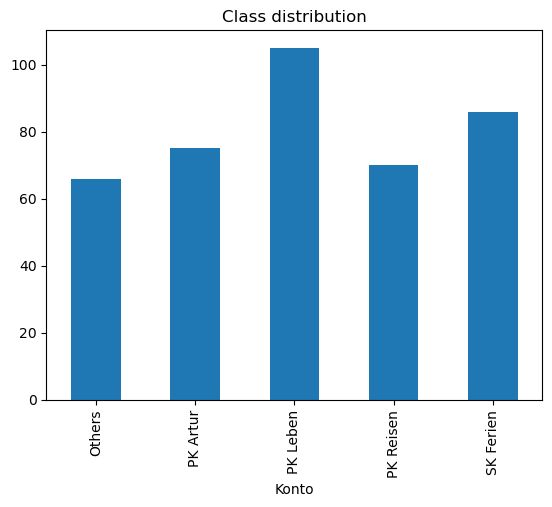

,description,Konto
0,Top-Up by *4356,Others
1,Refund from Amz*smithy By Dagmar N,Others
2,Splasz Studio Detailin,Others
3,Kraken Detailing,Others
4,Cash at Bienczycki Pl Targowy,Others
5,Wegrzyn & Wegrzyn S.j.,Others
6,Ley Autowaschpark W5,Others
7,Gama-M,Others
8,Fikołki,Others
9,Mini Melts Spolka Z O.o,Others


In [102]:
n_classes = df.Konto.nunique()
print(f"Number of classes: {n_classes}")

target_names = df.Konto.unique()
print(f"Class names: {target_names}")

print(df.groupby("Konto").Konto.count())
df.groupby("Konto").Konto.count().plot(kind="bar", ylim=0, )
plt.title("Class distribution")
plt.show()

# df["Konto"].astype("category").cat.codes.plot(kind="hist", color="green", width=0.8)
# plt.show()
# df.info()

pd.concat( [df.head(10), df.tail(10)] )

Histogram of words

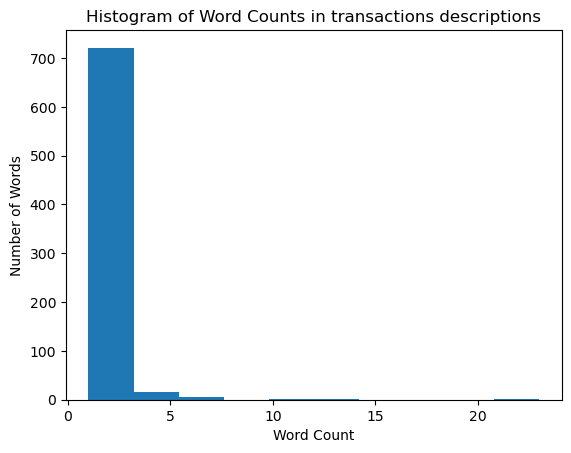

In [103]:
words = df.description.str.lower().str.split()
word_counts = words.explode().value_counts()
word_counts.plot(kind='hist')
plt.xlabel('Word Count')
plt.ylabel('Number of Words')
plt.title('Histogram of Word Counts in transactions descriptions')
plt.show()

Because there is long tail I will show also visualization of percentiles. This shows, that over 85% of words occures only ones in whole corpus and less then 15% of words occures more then once. 

# This means that word embeddings would not be the optimal technic for feature eingineering here.

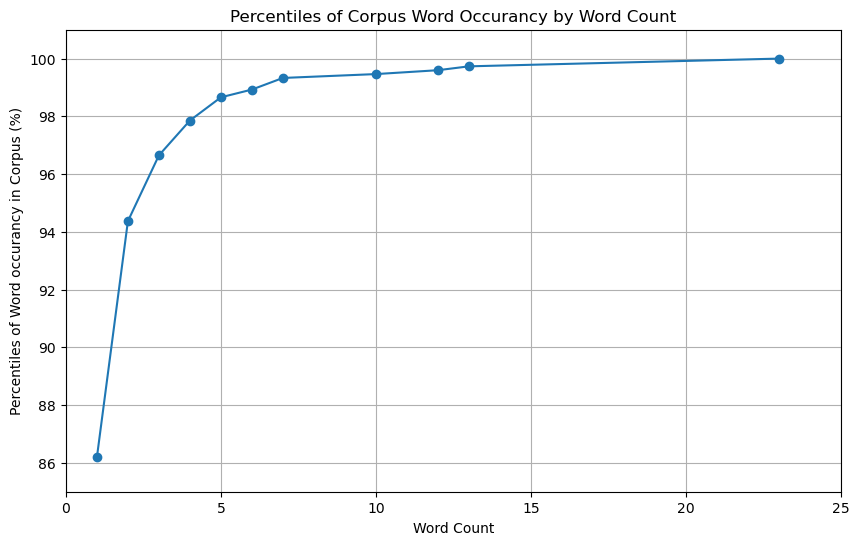

In [104]:
percentiles = word_counts.value_counts().sort_index().cumsum() / len(word_counts) * 100

# Plotting the percentiles
plt.figure(figsize=(10, 6))
plt.plot(percentiles.index, percentiles.values, marker='o')
plt.xlabel('Word Count')
plt.ylabel('Percentiles of Word occurancy in Corpus (%)')
plt.title('Percentiles of Corpus Word Occurancy by Word Count')
plt.grid(True)
plt.xlim(0, 25)
plt.ylim(85, 101)
plt.show()

Seaborn

In [105]:
# sns.set_theme()
# #df.groupby("Konto").Konto.count()
# sns.countplot(data=df, x="Konto")

Stopwords

In [106]:
stops_eng = set(stopwords.words('english'))
stops_ger = set(stopwords.words('german'))
stops_ita = set(stopwords.words('italian'))
stops_spa = set(stopwords.words('spanish'))
stops_fra = set(stopwords.words('french'))
link = "https://raw.githubusercontent.com/bieli/stopwords/master/polish.stopwords.txt"
lines=[]
responce = urllib.request.urlopen(link)
stops_pol = responce.read().decode().split(f"\n")

stops = list(stops_eng.union(stops_ger).union(stops_ita).union(stops_spa).union(stops_fra).union(stops_pol))


## Split Train-Test

In [107]:
X = df['description']
Y = df['Konto']

X_train_txt, X_test_txt, y_train_txt, y_test_txt = train_test_split(X, Y, test_size=0.3)

print(f"Trainig dataset: {X_train_txt.shape}, {y_train_txt.shape}")
print(f"Testing dataset: {X_test_txt.shape}, {y_test_txt.shape}")

Trainig dataset: (281,), (281,)
Testing dataset: (121,), (121,)


Encoding Labels

In [108]:
label_encoder = {'Others':0, 'PK Artur': 1, 'PK Leben': 2, 'PK Reisen': 3, 'SK Ferien': 4}
y_train = np.array([label_encoder[label] for label in y_train_txt])
y_test = np.array([label_encoder[label] for label in y_test_txt])

## Vecorization: Bag of Words

Training data

In [109]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts_bow = count_vect.fit_transform(X_train_txt) # this will fit() the model
X_train_arr_bow = X_train_counts_bow.toarray()

X_train_arr_bow.shape
#count_vect.vocabulary_["asfinag"]
#len(count_vect.vocabulary_)
np.nonzero(X_train_arr_bow[0])
for i in [ 55, 535]:
    a = [k for (k, v) in count_vect.vocabulary_.items() if v == i]
    print(a)

['automat']
[]


Testing data

In [110]:
X_test_counts_bow = count_vect.transform(X_test_txt) # this will predict() the model - here was just transform instead fit_transform as for training
X_test_counts_bow.toarray().shape

(121, 529)

Model training

In [111]:
log_reg_bow = LogisticRegression(max_iter=1000)
log_reg_bow.fit(X_train_counts_bow, y_train)

LogisticRegression(max_iter=1000)

Model testing on training data

In [112]:
y_train_pred_bow = log_reg_bow.predict(X_train_counts_bow)
accuracy_score(y_train, y_train_pred_bow)

0.99644128113879

Model testing on test data

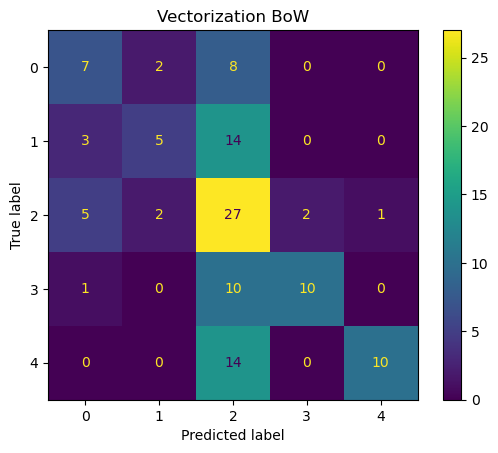

              precision    recall  f1-score   support

           0       0.44      0.41      0.42        17
           1       0.56      0.23      0.32        22
           2       0.37      0.73      0.49        37
           3       0.83      0.48      0.61        21
           4       0.91      0.42      0.57        24

    accuracy                           0.49       121
   macro avg       0.62      0.45      0.48       121
weighted avg       0.60      0.49      0.49       121



0.48760330578512395

In [113]:
y_test_pred_bow = log_reg_bow.predict(X_test_counts_bow)
test_pred_probas = {}
test_pred_probas["bow"] = log_reg_bow.predict_proba(X_test_counts_bow)

confusion_matrix_testing_bow = confusion_matrix(y_test, y_test_pred_bow)
# disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_testing_bow, display_labels=target_names)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_testing_bow)
disp.plot()
disp.ax_.set_title("Vectorization BoW")
plt.show()

from sklearn.metrics import classification_report
classification_report = classification_report(y_test, y_test_pred_bow)
print(classification_report)
c_report = {}
c_report["bow"] = classification_report

log_reg_bow_accuracy = accuracy_score(y_test, y_test_pred_bow)
log_reg_bow_accuracy


ROC

## Vectorization TF-IDF

Training data

In [114]:
tfidf_vect = TfidfVectorizer(
    #min_df=0.0001,
    #stop_words=stops, # without stops accuracy +0.01 precision +0.01 recall -0.01
    #max_features=1000,
    sublinear_tf=True, 
    #norm='l2', 
    ngram_range=(1, 2))
X_train_counts_tfidf = tfidf_vect.fit_transform(X_train_txt)
print(f"X_train_counts shape:\n{X_train_counts_tfidf.toarray().shape}")

X_train_counts shape:
(281, 880)


Lets see tfidf scores

In [115]:
X_array_tfidf = X_train_counts_tfidf.toarray()
np.nonzero(X_array_tfidf[0])

(array([211, 511, 512], dtype=int64),)

In [116]:
for i in [129, 593, 594]:
    print(X_array_tfidf[0][i])

0.0
0.0
0.0


Testing data

In [117]:
X_test_counts_tfidf = tfidf_vect.transform(X_test_txt)
X_test_counts_tfidf.toarray().shape

(121, 880)

Model training

In [118]:
log_reg_tfidf = LogisticRegression(max_iter=1000
                                   # , C=0.8
                                   # , penalty="l2"
                                   # , class_weight="balanced"
                                   )
log_reg_tfidf.fit(X_train_counts_tfidf, y_train)

LogisticRegression(max_iter=1000)

Testing on trainig data

In [119]:
y_train_pred_tfidf = log_reg_tfidf.predict(X_train_counts_tfidf)
accuracy_score(y_train, y_train_pred_tfidf)

0.99644128113879

Model testing on test data

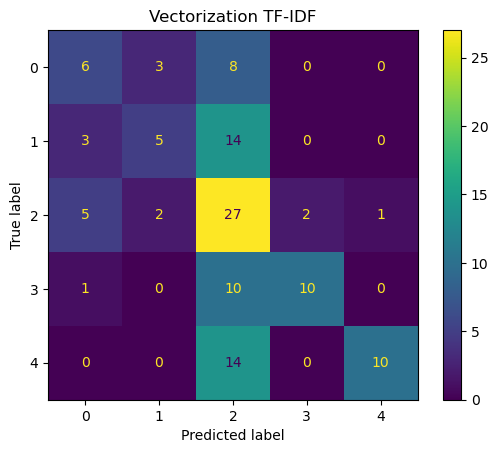

              precision    recall  f1-score   support

           0       0.40      0.35      0.38        17
           1       0.50      0.23      0.31        22
           2       0.37      0.73      0.49        37
           3       0.83      0.48      0.61        21
           4       0.91      0.42      0.57        24

    accuracy                           0.48       121
   macro avg       0.60      0.44      0.47       121
weighted avg       0.59      0.48      0.48       121



0.4793388429752066

In [120]:
y_test_pred_tfidf = log_reg_tfidf.predict(X_test_counts_tfidf)
test_pred_probas["tfidf"] = log_reg_tfidf.predict_proba(X_test_counts_tfidf)


confusion_matrix_testing_tfidf = confusion_matrix(y_test, y_test_pred_tfidf)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_testing_tfidf)
disp.plot()
disp.ax_.set_title("Vectorization TF-IDF")
plt.show()

from sklearn.metrics import classification_report
classification_report = classification_report(y_test, y_test_pred_tfidf)
print(classification_report)
c_report["tfidf"] = classification_report

log_reg_tfidf_accuracy = accuracy_score(y_test, y_test_pred_tfidf)
log_reg_tfidf_accuracy

## Vectorization: Word Embeddings - gensim

Vectorizer Preperation

In [121]:
import gensim.downloader as api
#word_vectors = api.load('glove-wiki-gigaword-100') # acc 0.46
word_vectors = api.load('glove-wiki-gigaword-50') # acc 0.38
# word_vectors = api.load('glove-wiki-gigaword-300') # acc 0.38
word_vectors.vector_size

50

In [122]:
len(word_vectors.key_to_index)

400000

Average of words in document and gize back vector filled with zeros when word can not be found in gensim embeddings

In [123]:
def document_vector(doc):
    doc = [word for word in doc if word in word_vectors.key_to_index]
    if not doc:
        return np.zeros(word_vectors.vector_size)
    return np.mean(word_vectors[doc], axis=0)

Vectorization

In [124]:
X_train_txt_split = X_train_txt.str.lower().str.split()
X_test_txt_split = X_test_txt.str.lower().str.split()

X_train_vec = np.array([document_vector(d) for d in X_train_txt_split])
X_test_vec = np.array([document_vector(d) for d in X_test_txt_split])
X_train_vec.shape

(281, 50)

Model training

In [125]:
log_reg_embeddings = LogisticRegression(max_iter=1000)
log_reg_embeddings.fit(X_train_vec, y_train)

LogisticRegression(max_iter=1000)

Model testing on training data

In [126]:
y_train_pred_embeddings = log_reg_embeddings.predict(X_train_vec)
accuracy_score(y_train, y_train_pred_embeddings)

0.6441281138790036

Model testing on testing data

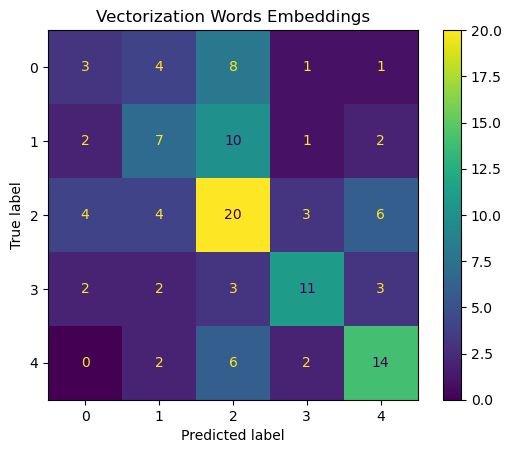

              precision    recall  f1-score   support

           0       0.27      0.18      0.21        17
           1       0.37      0.32      0.34        22
           2       0.43      0.54      0.48        37
           3       0.61      0.52      0.56        21
           4       0.54      0.58      0.56        24

    accuracy                           0.45       121
   macro avg       0.44      0.43      0.43       121
weighted avg       0.45      0.45      0.45       121



0.45454545454545453

In [127]:
y_test_pred_embeddings = log_reg_embeddings.predict(X_test_vec)
test_pred_probas["embeddings"] = log_reg_embeddings.predict_proba(X_test_vec)

confusion_matrix_testing_embeddings = confusion_matrix(y_test, y_test_pred_embeddings)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_testing_embeddings)
disp.plot()
disp.ax_.set_title("Vectorization Words Embeddings")
plt.show()

from sklearn.metrics import classification_report
classification_report = classification_report(y_test, y_test_pred_embeddings)
print(classification_report)
c_report["embeddings"] = classification_report

log_reg_embeddings_accuracy = accuracy_score(y_test, y_test_pred_embeddings)
log_reg_embeddings_accuracy

## Metrics together BoW, TF-IDF, Embeddings

In [128]:
def draw_multiclass_roc(y_train_txt, y_test_txt, y_test_pred_proba, text=""):
    from sklearn.preprocessing import LabelBinarizer

    label_binarizer = LabelBinarizer().fit(y_train_txt)
    y_onehot_test = label_binarizer.transform(y_test_txt)
    y_onehot_test.shape  # (n_samples, n_classes)
    class_of_interest = "Others"
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]


    from sklearn.metrics import auc, roc_curve, RocCurveDisplay
    # store the fpr, tpr, and roc_auc for all averaging strategies
    fpr, tpr, roc_auc = dict(), dict(), dict()
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_test_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")


    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_test_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)
    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    # Average it and compute AUC
    mean_tpr /= n_classes
    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    # print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")
    
    # the same as this, but we need previous calculations to draw all classes
    # from sklearn.metrics import roc_auc_score
    # macro_roc_auc_ovr = roc_auc_score(
    #     y_test,
    #     y_test_pred_proba_bow,
    #     multi_class="ovr",
    #     average="macro",
    # )
    # print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")


    from itertools import cycle
    fig, ax = plt.subplots(figsize=(6, 6))

    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "hotpink", "lightgreen"])
    for class_id, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_test_pred_proba[:, class_id],
            name=f"ROC curve for {target_names[class_id]}",
            color=color,
            ax=ax,
            plot_chance_level=(class_id == 2),
        )

    _ = ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"{text} Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass",
    )

In [129]:
for vec_kind in ["bow", "tfidf", "embeddings"]:
    print(f"Vectorizing kind: {vec_kind}")
    print(c_report[vec_kind])

Vectorizing kind: bow
              precision    recall  f1-score   support

           0       0.44      0.41      0.42        17
           1       0.56      0.23      0.32        22
           2       0.37      0.73      0.49        37
           3       0.83      0.48      0.61        21
           4       0.91      0.42      0.57        24

    accuracy                           0.49       121
   macro avg       0.62      0.45      0.48       121
weighted avg       0.60      0.49      0.49       121

Vectorizing kind: tfidf
              precision    recall  f1-score   support

           0       0.40      0.35      0.38        17
           1       0.50      0.23      0.31        22
           2       0.37      0.73      0.49        37
           3       0.83      0.48      0.61        21
           4       0.91      0.42      0.57        24

    accuracy                           0.48       121
   macro avg       0.60      0.44      0.47       121
weighted avg       0.59      0.

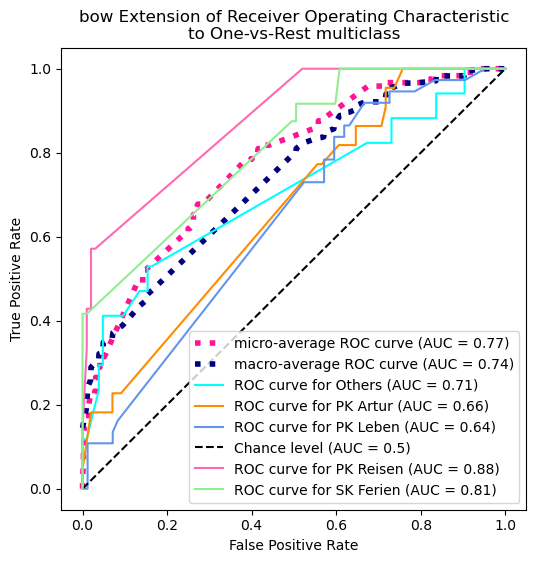

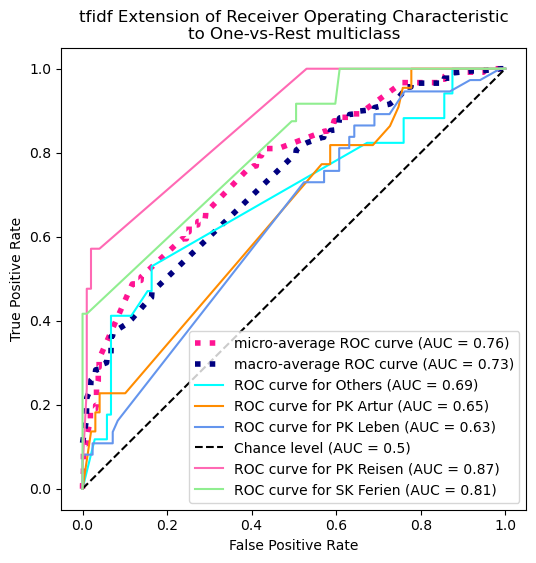

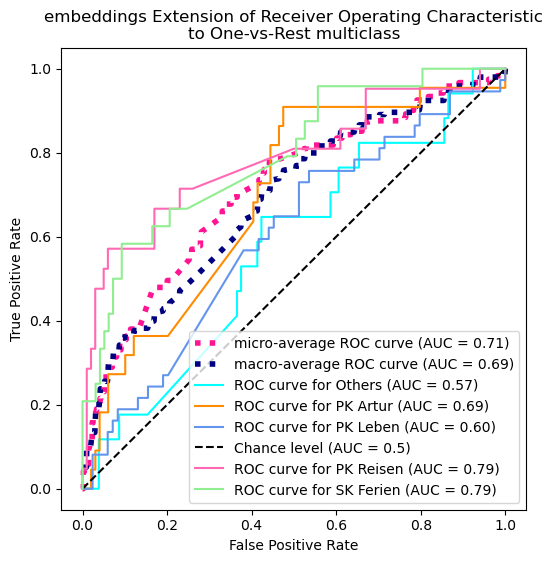

In [130]:
for vec_kind in ["bow", "tfidf", "embeddings"]:
    draw_multiclass_roc(y_train_txt, y_test_txt, test_pred_probas[vec_kind], vec_kind)


## Artur's tests
Train model

In [131]:


# pipeline = Pipeline([('vect', tfidf_vect),
#                      #('chi',  SelectKBest(chi2, k="all")),
#                      ('clf',  LogisticRegression(multi_class='ovr'
#                                                  , solver='liblinear'
#                                                  , random_state=42
#                                                  , C=0.3
#                                                  , penalty="l2"
#                                                  , class_weight="balanced"))])
# 
# model = pipeline.fit(X_train_txt, y_train)

Show model params

In [132]:
# print( model["clf"].coef_)
# print( model["clf"].intercept_)